Dans cet atelier nous allons entrainer un modèle machine learning avec Scikit-Learn et puis le déployer en tant que web service local et aussi en tant que web service ACI "Azure Container Instance". 

Les étapes de cet Atelier sont les suivantes: 

1. entrainer localement un modèle Scikit-learn
2. Suivre les expérimentations Scikit-learn avec MLFlow sur Azure Machine Learning 
3. Enregistrer le modèle sur Azure Machine Learning 
4. Déployer et tester le modèle en tant que web service local 
5. Déployer et tester le modèle en tant que web service ACI "Azure Container Instance"

Tout au long de cet atelier nous allons utiliser Pima Indians Diabetes Database. Pour de plus amples informations sur les colonnes, visitez le lien ci-dessous: 

https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

## 1. L'entrainement du modèle Scikit-Learn 

Assurez vous que vous avez installé anaconda avec une version de python 3.7.*

Assurez vous aussi que vous avez Docker installé : https://docs.docker.com/desktop/install/windows-install/ 

Dans le dossier de l'atelier, installez les dépendances requises: pip install -r requirements.txt 

* azureml-core==1.39
* pandas==1.3.5
* scikit-learn==0.24.2
* cloudpickle==2.0.0
* psutil==5.9.0
* mlflow==1.24.0

In [3]:
%env PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

env: PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python


In [4]:
import mlflow
from azureml.core import Workspace
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

In [5]:
print(mlflow.__version__)

1.24.0


In [6]:
import warnings

warnings.filterwarnings("ignore")

Pour se connecter au workspace Azure machine learning, deux cas se présentent: 

1. Télecharger le fichier de configuration et appeler le en utilisant ws = Workspace.from_config() 

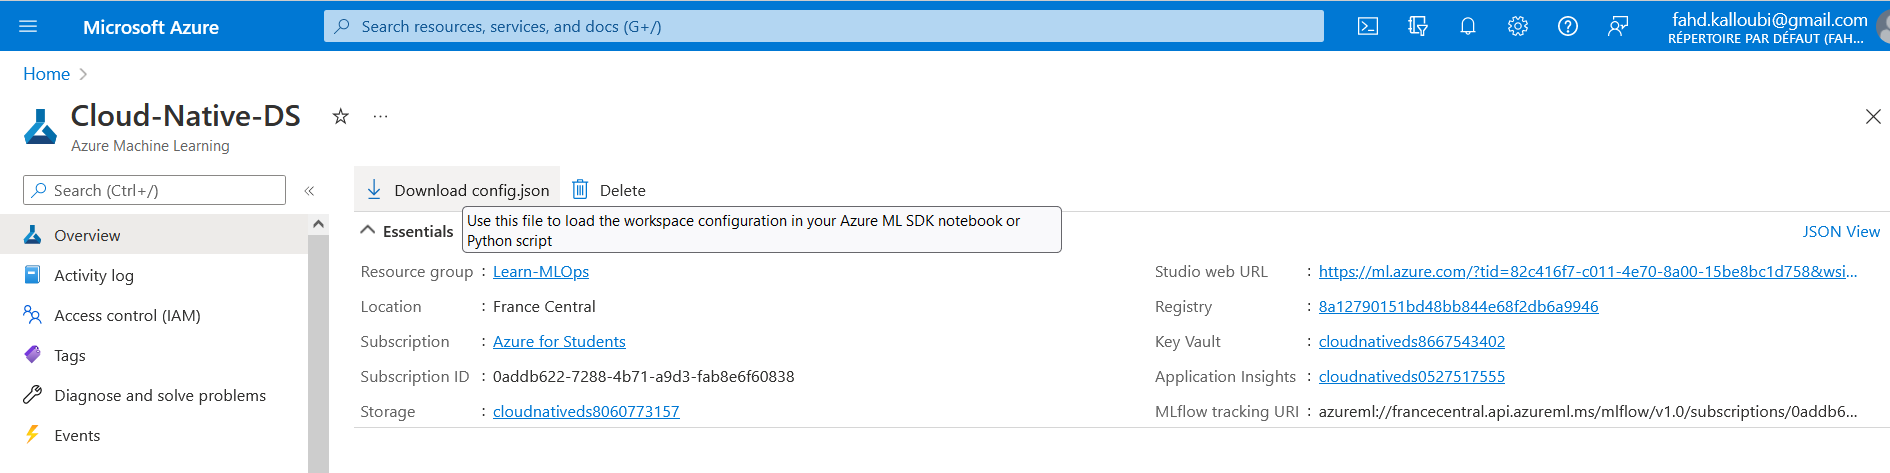

2. Ou bien en entrant manuellement les informations nécessaires, comme indiqué dans la cellule suivante.

In [7]:
# ws = Workspace.from_config()
subscription_id = "94130a70-a851-4f74-8238-f69b35458860"
resource_group = "Learn_MLOps"
workspace_name = "MLOps_WS"
workspace_location = "France Central"
ws = Workspace.create(
    name=workspace_name,
    location=workspace_location,
    resource_group=resource_group,
    subscription_id=subscription_id,
    exist_ok=True,
)

#### Mettre en place un URI de Tracking des experimentation MLflow sur Azure

Nous indiquons à mlflow que l'URI de tracking est celui de mlflow dans azure ML. Toutefois, le lien de tracking de Mlflow dans azure à la forme suivante:

azureml://<region>.api.azureml.ms/mlflow/v1.0/subscriptions/<subscription-id>/resourceGroups/<resource-group>/providers/Microsoft.MachineLearningServices/workspaces/<aml-workspace>?

In [10]:
!pip install azureml-mlflow

Nous allons créer une expérimentation Mlflow dont le nom est "diabetes-sklearn" 

In [13]:
experiment_name = "diabetes-sklearn"
mlflow.set_experiment(experiment_name)

2024/01/07 01:29:15 INFO mlflow.tracking.fluent: Experiment with name 'diabetes-sklearn' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/omomani/Desktop/i/new_year/azure/Atelier%206%20microservices%20API%20ACI%20ACS%20Heroku%20%283%29/Dossier%20Atelier%20microservices%20API%20ACI%20ACS%20Heroku/Azure%20MLflow%20Deploy/mlruns/1', experiment_id='1', lifecycle_stage='active', name='diabetes-sklearn', tags={}>

#### chargement du dataset et traitements necéssaires 

In [15]:
df = pd.read_csv("diabetes.csv")

In [16]:
df.shape

(768, 9)

In [17]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [20]:
df_scaled

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.46849198,
         1.4259954 ,  1.36589591],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.36506078,
        -0.19067191, -0.73212021],
       [ 1.23388019,  1.94372388, -0.26394125, ...,  0.60439732,
        -0.10558415,  1.36589591],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.68519336,
        -0.27575966, -0.73212021],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.37110101,
         1.17073215,  1.36589591],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.47378505,
        -0.87137393, -0.73212021]])

In [21]:
x = df.iloc[:, :-1]
y = df.iloc[:, -1:]

In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [23]:
print("X_train:", x_train.shape)
print("X_test:", x_test.shape)
print("Y_train:", y_train.shape)
print("Y_test:", y_test.shape)

X_train: (614, 8)
X_test: (154, 8)
Y_train: (614, 1)
Y_test: (154, 1)


In [24]:
rf_clf = RandomForestClassifier()

Au lieu d'appeler a chaque fois une fonction de logging (log_metric, log_artifact, ...) nous allons utiliser la fonction autolog() afin de logger toutes les informations relatives au modèle (metrics, parameters, ...) 

les frameworks suivants supporte la fonction autolog():

    Scikit-learn

    TensorFlow and Keras

    Gluon

    XGBoost

    LightGBM

    Statsmodels

    Spark

    Fastai

    Pytorch



In [25]:
mlflow.sklearn.autolog(max_tuning_runs=None)

#### Hyperparameter tuning 

Nous alons utiliser l'algorithme GridSearchCV pour trouver les meilleurs paramétres

In [26]:
param_grid = {"n_estimators": [10, 20, 30], "max_depth": [2, 7, 10]}

In [28]:
gridcv = GridSearchCV(
    rf_clf,
    param_grid=param_grid,
    scoring=["roc_auc", "precision", "recall", "f1", "accuracy"],
    refit="roc_auc",
    cv=10,
)

In [30]:
gridcv.fit(x_train, y_train)

2024/01/07 01:30:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '982f203c542046eea57702236d8edca6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2024/01/07 01:30:05 WARNING mlflow.sklearn.utils: _get_classifier_artifacts.<locals>.plot_confusion_matrix failed. The artifact training_confusion_matrix will not be recorded. Artifact error: No module named 'matplotlib'


GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 7, 10], 'n_estimators': [10, 20, 30]},
             refit='roc_auc',
             scoring=['roc_auc', 'precision', 'recall', 'f1', 'accuracy'])

#### visualisation des résultats sur Azure ML experiments

Les résultats du tracking et logging avec Mlflow peuvent être visualisés sur Azure machine learning studio en cliquant sur "Jobs" et puis sur le nom de l'experimentation (pour notre cas: diabetes-sklearn)

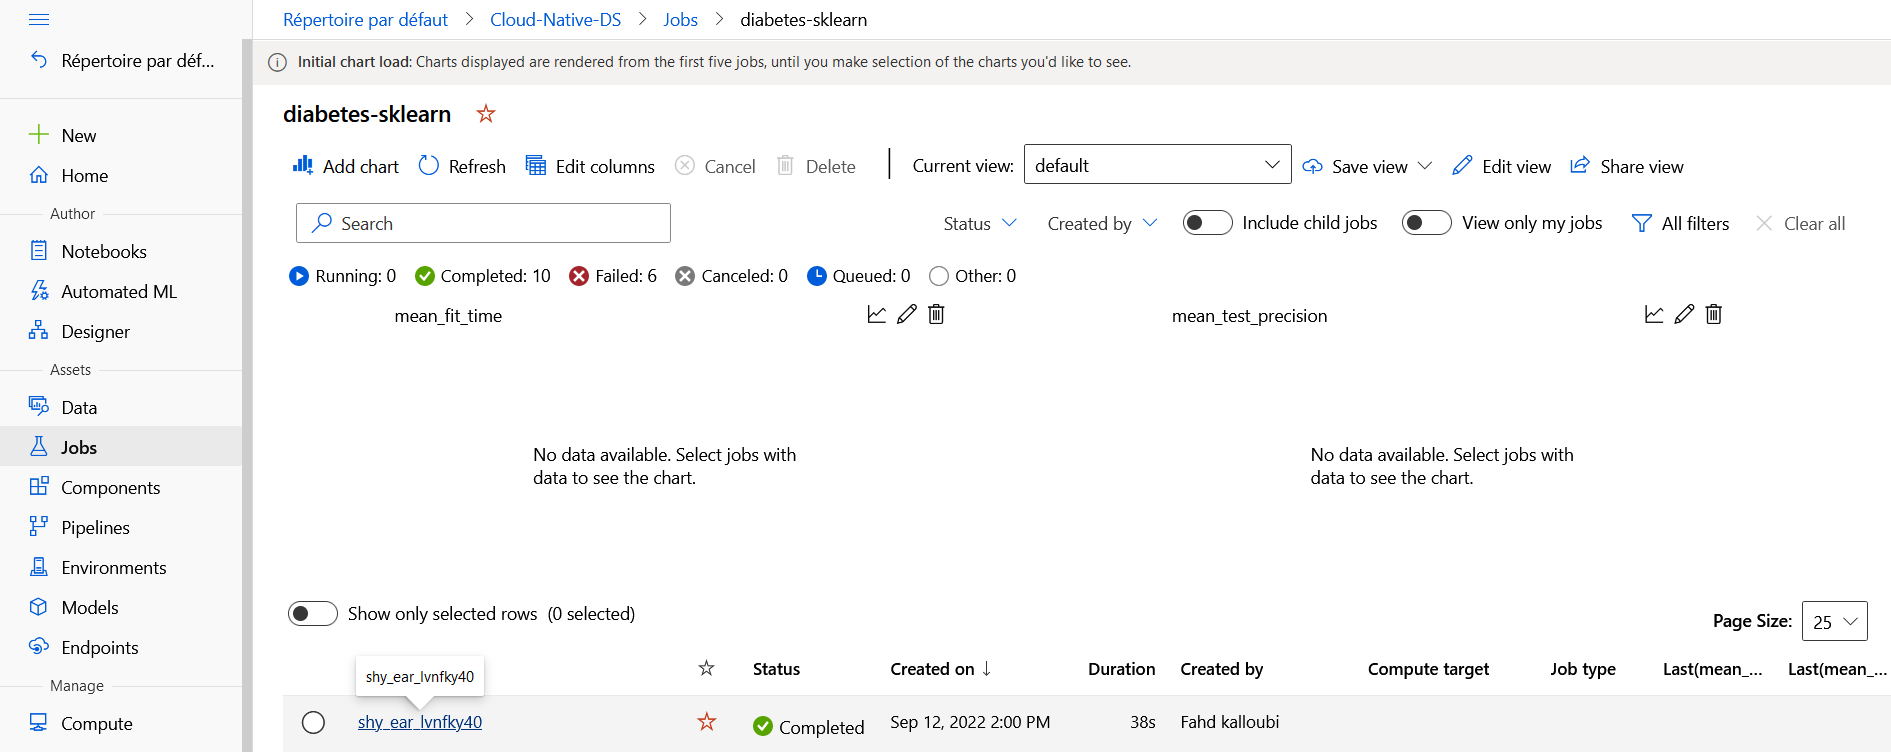

En cliquant sur le dernier job vous pouvez voir les résultats Mlflow de notre logging 

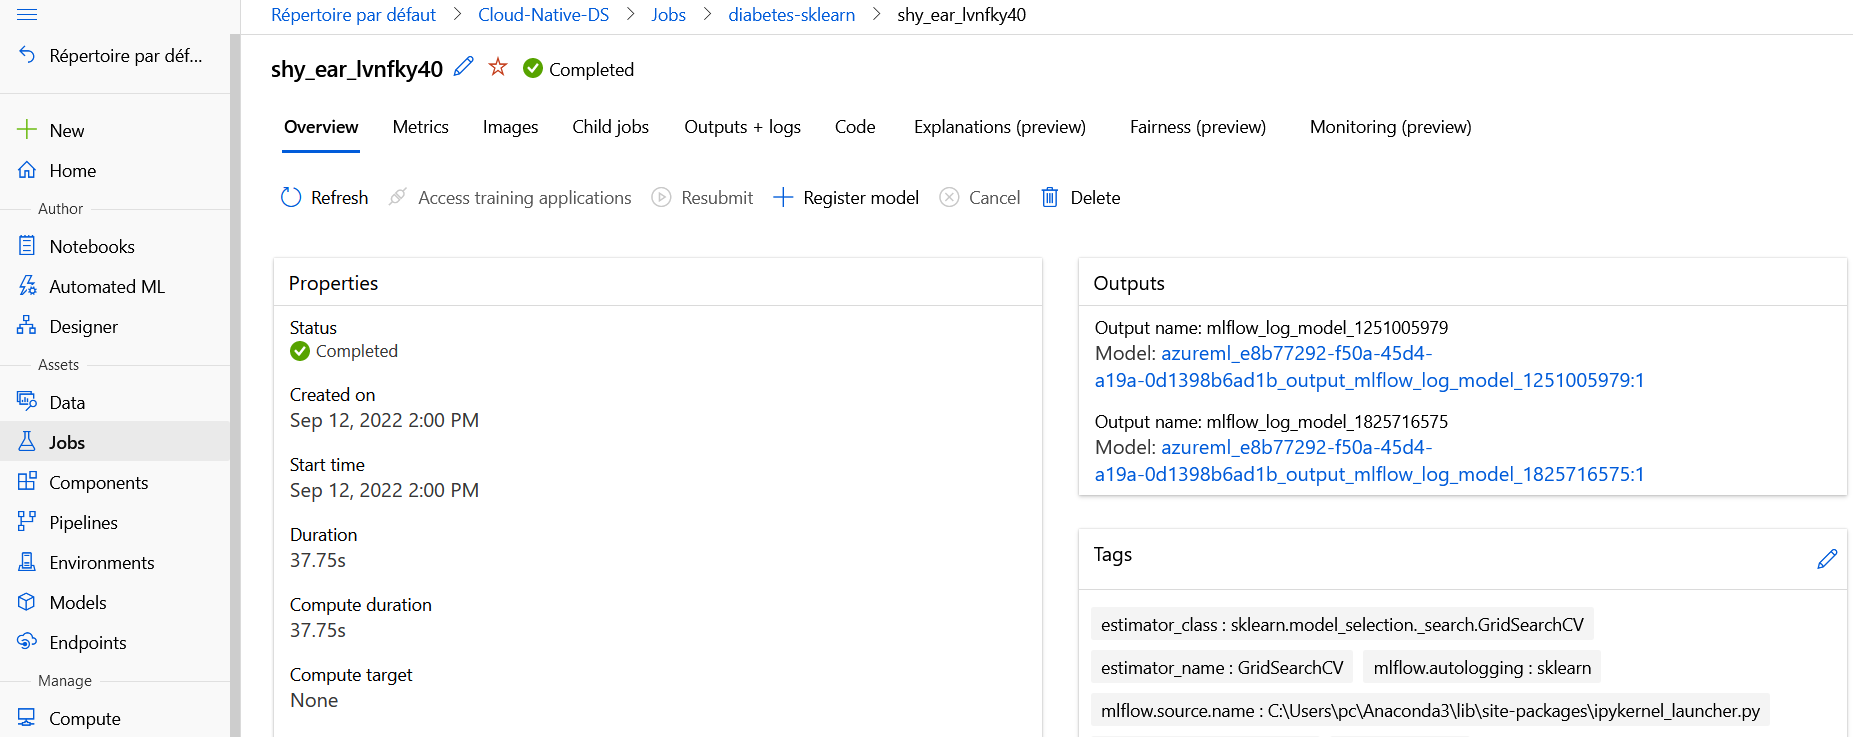

les artifacts et run_id du meilleur modèle peuvent être trouvés en cliquent sur l'onglet "output+logs"

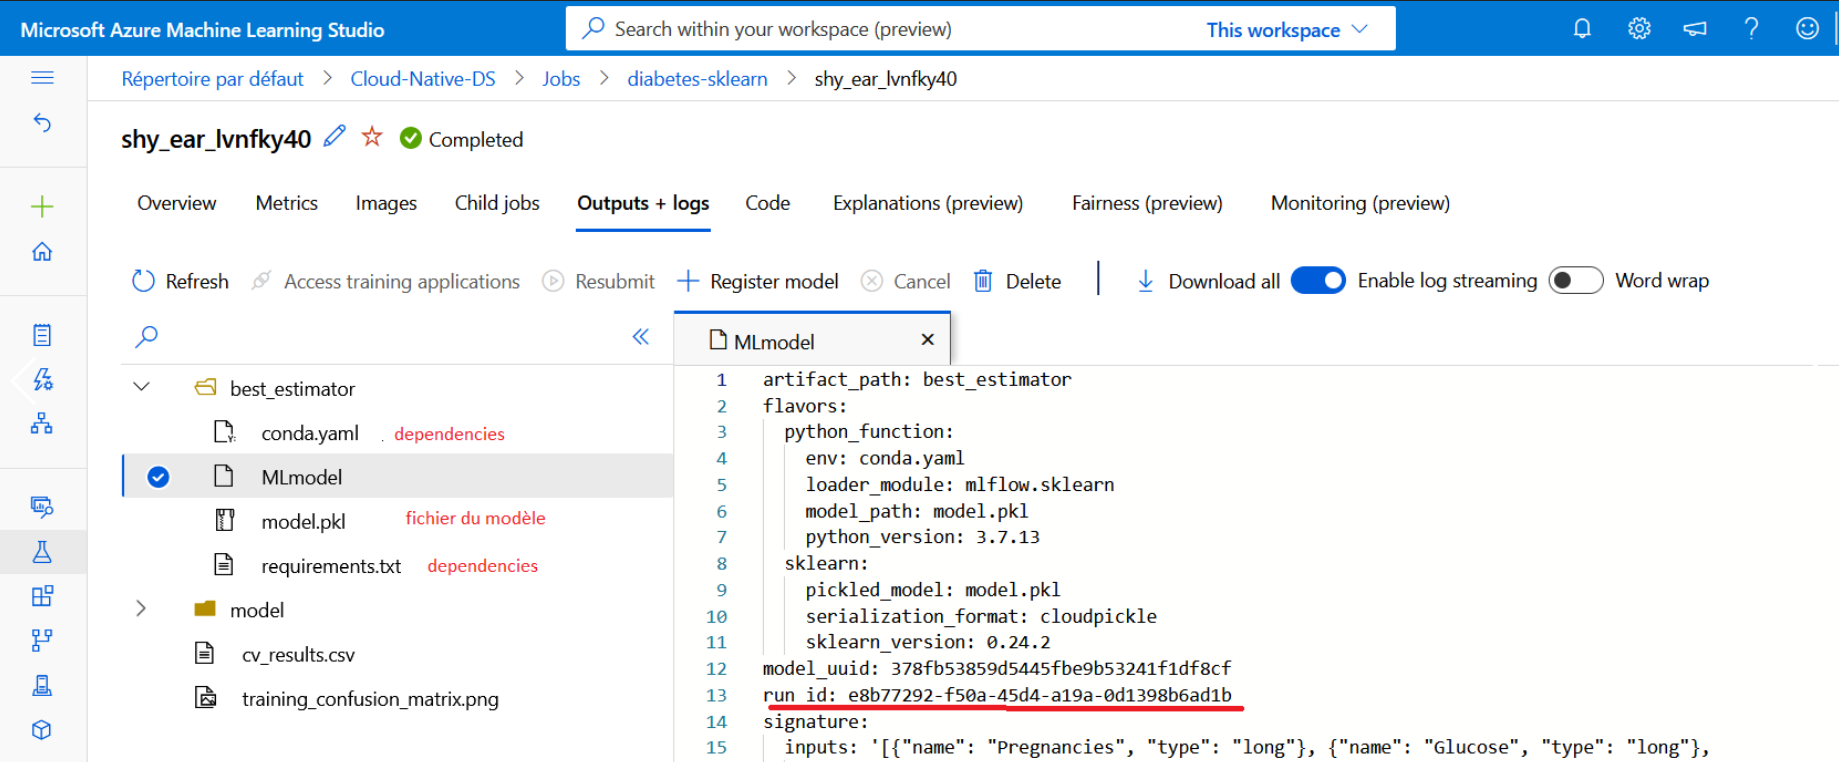



In [31]:
# modelLogistic = LogisticRegression()
# modelLogistic.fit(x_train,y_train)

In [32]:
# parameters={'penalty':['l1','l2'],"C":[1,2,3,4,5,10,100],'max_iter':[10,20,30]}

In [33]:
# mlflow.sklearn.autolog(max_tuning_runs=None)
# gridcv=GridSearchCV(modelLogistic,param_grid=parameters,scoring = ['roc_auc', 'precision', 'recall', 'f1', 'accuracy'],refit = 'roc_auc',cv=10)

In [34]:
# gridcv.fit(x_train,y_train)

## 2.  L'enregistrement du modèle 
L'enregistrement du modèle dans le registre de modèles d'Azure Machine Learning a pour but de permettre aux utilisateurs de suivre les modifications apportées au modèle via la gestion des versions du modèle.

nous allons trouver l'expérimentation à partir du workspace en définant le workspace et le nom de l'expérimentation 

In [35]:
from azureml.core import Experiment, Workspace

experiment_name = "diabetes-sklearn"
experiment = Experiment(ws, experiment_name)

In [36]:
# afficher tous les runs
for r in experiment.get_runs():
    print(r)

Run(Experiment: diabetes-sklearn,
Id: 1756732e-29b1-41aa-86a6-f98115b65e31,
Type: None,
Status: Completed)


Trouver le Run actuel 

In [37]:
run_id = "1756732e-29b1-41aa-86a6-f98115b65e31"
run = [r for r in experiment.get_runs() if r.id == run_id][0]

Enregistrer le modèle 

    model_name: un nom arbitraire pour enregister le modèle 
    model_path: chemin vers  model.pkl

In [40]:
model = run.register_model(
    model_name="diabetes_model", model_path="best_estimator/model.pkl"
)

on peut visualiser nos modèle enregistés en visitant "Models"

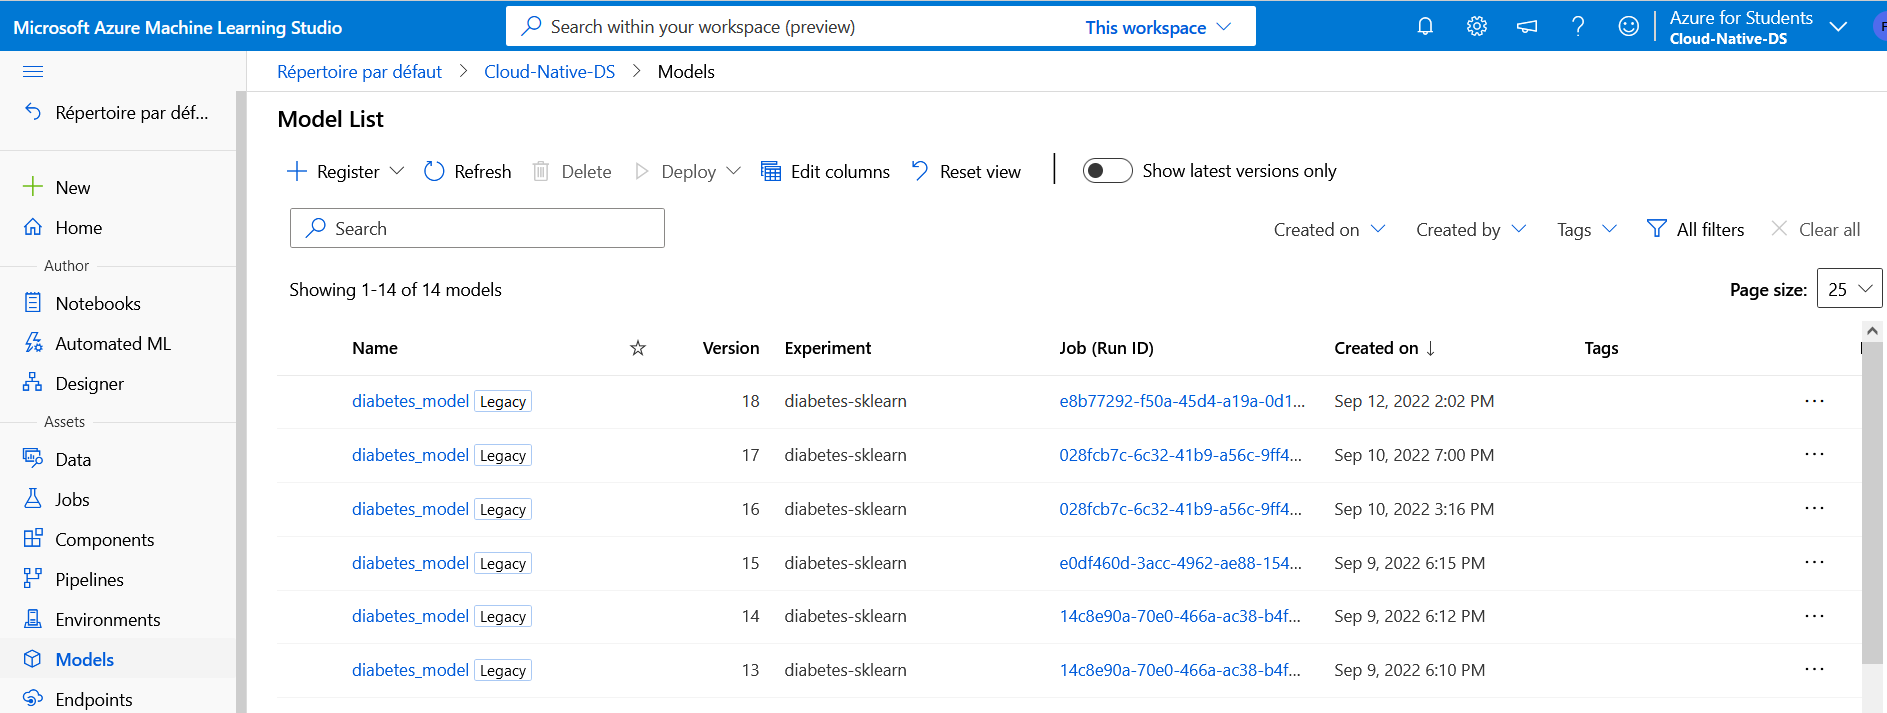

N.B: La dernière version enregistrée du modèle est 18 

## 3. la création d'un script de Scoring

Le script de scoring généralement appelé score.py est utilisé lors de l'inférence comme point d'entrée du modèle.

score.py (voir le dossier de l'atelier) consiste en deux fonctions obligatoires:

1. init(): charge le modèle en tant que variable globale
2. run(): reçoit les nouvelles données à prédire à travers le paramètre data
      * effectue un pré-traitement des nouvelles données (optionnel)
      * effectue une prédiction sur les nouvelles données
      * effectue un post-traitement sur les prédictions (optionnel)
      * renvoie les résultats de la prédiction

## 4. Déploiement en local

Maintenant nous allons debuger le web service locallement avant de le déployer en production avec ACI " Azure container Instance"

Récupérez le modèle enregistré en définissant le workspace, le nom du modèle et la version du modèle.

In [41]:
from azureml.core.model import Model

model = Model(ws, "diabetes_model", version=1)

### la création d'un environnement d'inférence personnalisé 
Lors de l'entrainement du modèle, nous avons enregistré les dépendances de l'environnement dans MLFlow sous la forme d'un fichier conda.yaml. Nous utiliserons ce fichier pour créer un environnement d'inférence personnalisé.

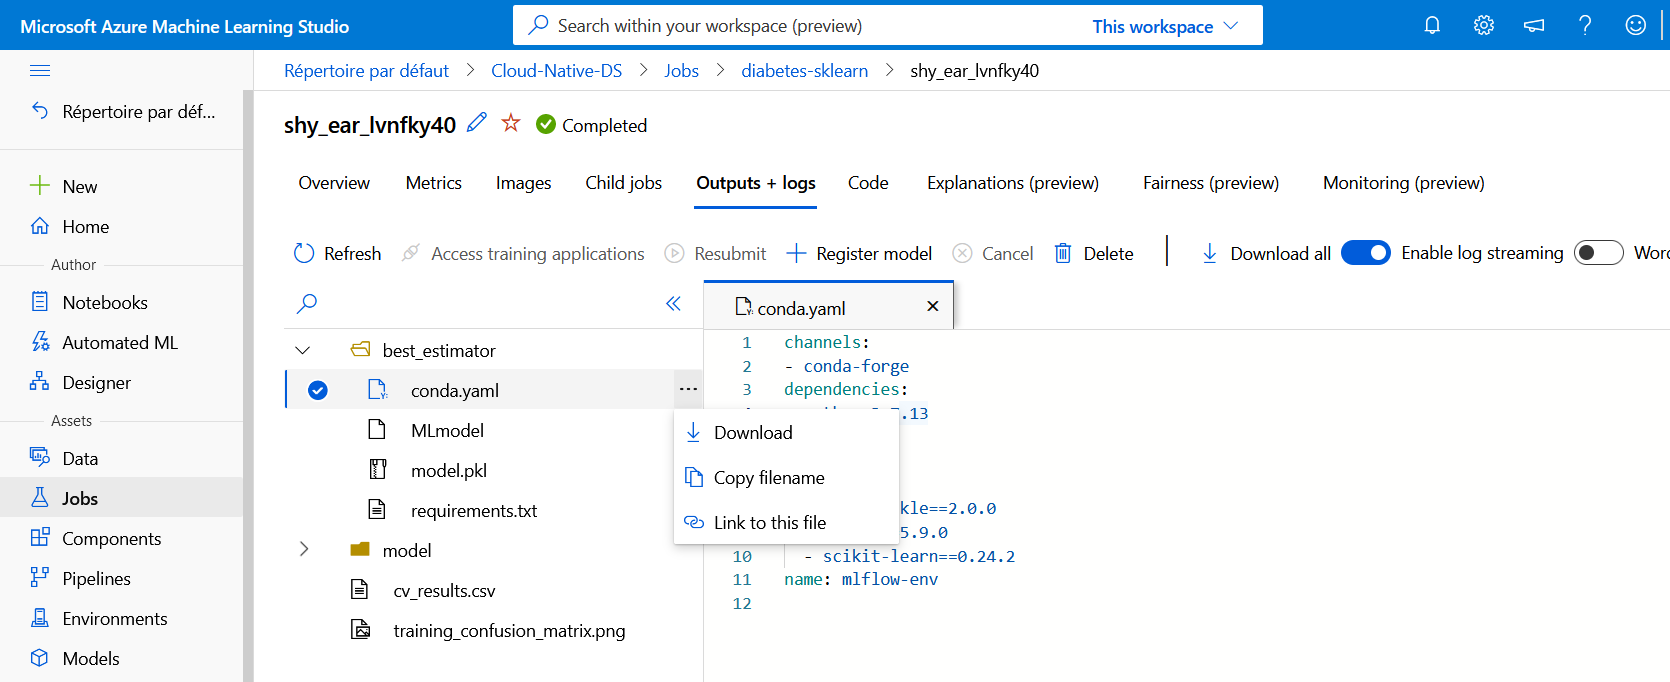

Téléchargez le fichier conda.yml vers le dossier de l'atelier (déjà faite pour vous) et rajoutant d'autres dépendances comme: azureml-defaults==1.43, applicationinsights

le fichier conda.yml aura l'allure suivante (voir le dossier de l'atelier):

channels:
- conda-forge
dependencies:
- python=3.7.3
- pip
- pip:
  - mlflow
  - cffi==1.12.2
  - cloudpickle==2.0.0
  - pillow==5.4.1
  - psutil==5.9.0
  - scikit-learn==0.24.2
  - azureml-defaults==1.43
  - applicationinsights
name: mlflow-env

Nous allons nous baser sur ce fichier pour créer un environnement personnalisé 

après enregistrement de cet environnement, nous pouvons le consulter dans la section "Environment" dans Azure Machine Learning et plus particulièrement dans l'onglet "Custom environments"

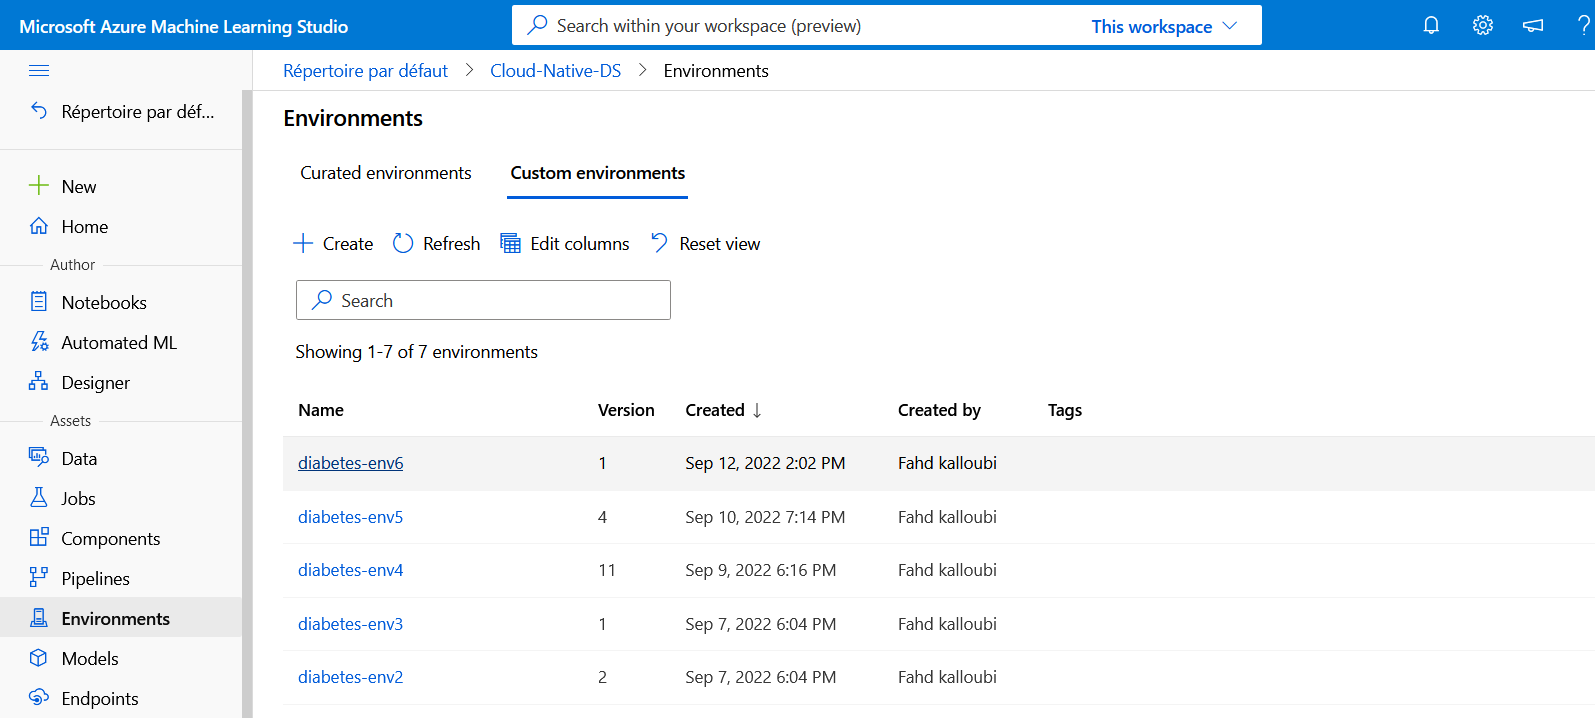

In [42]:
from azureml.core import Environment

env = Environment.from_conda_specification(
    name="diabetes-env6", file_path="./conda.yaml"
)
env.register(ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20220208.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": null,
    "name": "diabetes-env6",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "conda-forge"
            ],
            "

### Définons la configuration d'inférence 

In [43]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(
    environment=env,
    source_directory=".",
    entry_script="./score.py",
)

### Définons la configuration de déploiement

In [44]:
from azureml.core.webservice import LocalWebservice

deployment_config = LocalWebservice.deploy_configuration(port=6789)

### Déployons le service localement

Avant d'exécuter la cellule ci-dessous, assurez vous que Docker est démarré 

In [45]:
service = Model.deploy(
    workspace=ws,
    name="diabetes-prediction-service",
    models=[model],
    inference_config=inference_config,
    deployment_config=deployment_config,
    overwrite=True,
)

Generating Docker build context.
2024/01/06 22:31:09 Downloading source code...
2024/01/06 22:31:09 Finished downloading source code
2024/01/06 22:31:10 Creating Docker network: acb_default_network, driver: 'bridge'
2024/01/06 22:31:10 Successfully set up Docker network: acb_default_network
2024/01/06 22:31:10 Setting up Docker configuration...
2024/01/06 22:31:11 Successfully set up Docker configuration
2024/01/06 22:31:11 Logging in to registry: 7b84ffa7f53543649f53bcdf75b1232d.azurecr.io
2024/01/06 22:31:11 Successfully logged into 7b84ffa7f53543649f53bcdf75b1232d.azurecr.io
2024/01/06 22:31:12 Volume source scriptsFromEms successfully created
2024/01/06 22:31:12 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2024/01/06 22:31:12 Scanning for dependencies...
2024/01/06 22:31:12 Successfully scanned dependencies
2024/01/06 22:31:12 Launching container with name: acb_step_0
Sending build context to Docker daemon  77.31kB
Step 1/

In [46]:
service.wait_for_deployment(show_output=True)

Checking container health...
Local webservice is running at http://localhost:6789


Le fichier model.pkl sera téléchargé à partir d'Azure Machine Learning dans un dossier local temporaire et une image Docker avec les dépendances est créée et enregistrée dans Azure Container Registry (ACR). L'image sera téléchargée d'ACR sur la machine locale et un conteneur Docker exécutant le service Web est construit à partir de l'image localement.



Pour avoir l'URI de scoring lancez la commande suivante 

In [47]:
print(service.scoring_uri)

http://localhost:6789/score


## 5. Testons le service localement 

Pour tester le service localement, ouvrez le notebook "Inference_test.ipynb" et assigner l'URI de scroring à la variable scoring_uri

Nous avons envoyé une demande d'inference au scoring_uri avec les données au format JSON. Voici à quoi ressemble input_data :

{"input": "[{\"Pregnancies\":6,\"Glucose\":148,\"BloodPressure\":72,\"SkinThickness\":35,\"Insulin\":0,\"BMI\":33.6,\"DiabetesPedigreeFunction\":0.627,\"Age\":50}]"}


Voici un exemple de la réponse pour l'inférence sur un seul enregistrement. La valeur de retour contient la probabilité qu'une personne reçoive un diagnostic de diabète.

prediction: "{\"proba\": [0.4829951216899814]}"


Le format de réponse peut être personnalisé dans la fonction run du fichier score.py.

## 6. Déplyons le service sur ACI

In [48]:
from azureml.core import Environment
from azureml.core.model import Model
from azureml.core import Workspace

ws = Workspace.from_config()
model = Model(ws, "diabetes_model", version=1)
env = Environment.get(workspace=ws, name="diabetes-env6", version=1)

In [49]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(
    environment=env, source_directory=".", entry_script="./score.py"
)

In [50]:
from azureml.core.webservice import AciWebservice

deployment_config = AciWebservice.deploy_configuration(
    cpu_cores=0.1, memory_gb=0.5, auth_enabled=False
)

In [51]:
service = Model.deploy(
    workspace=ws,
    name="diabetes-prediction-service5",
    models=[model],
    inference_config=inference_config,
    deployment_config=deployment_config,
    overwrite=True,
)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2024-01-07 01:52:43+03:00 Creating Container Registry if not exists.
2024-01-07 01:52:43+03:00 Registering the environment.
2024-01-07 01:52:45+03:00 Use the existing image.
2024-01-07 01:52:45+03:00 Generating deployment configuration.
2024-01-07 01:52:46+03:00 Submitting deployment to compute.
2024-01-07 01:52:50+03:00 Checking the status of deployment diabetes-prediction-service5..
2024-01-07 01:54:14+03:00 Checking the status of inference endpoint diabetes-prediction-service5.
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [52]:
# service.delete()

In [53]:
print(service.scoring_uri)

http://02e7e882-e9e4-411e-8ed4-fb9d7ed8b7b5.francecentral.azurecontainer.io/score


### Testons le service 

Refaites la même chose en ouvrant le notebook "Inference_test.ipynb" et assigner le nouveau URI de scroring à la variable scoring_uri 

## Déploiement sur AKS "Azure Kubernetes Service" 

ACI est recommandé pour les tests sur une petite charge de travail de production. Pour une charge de travail importante azure fourni AKS "Azure Kubernetes Service"

Malheureusement le Déploiement sur AKS n'est pas pris en compte  avec notre sousription actuelle. 

Néanmoins, je vous ai fourni le code de déploiement pour une éventuelle utilisation future

In [54]:
from azureml.core.webservice import AksWebservice

deployment_config = AksWebservice.deploy_configuration(
    cpu_cores=1, memory_gb=1, auth_enabled=False
)

In [58]:
deployment_config.validate_configuration

<bound method AksServiceDeploymentConfiguration.validate_configuration of <azureml.core.webservice.aks.AksServiceDeploymentConfiguration object at 0x7f35eaec1990>>

In [61]:
# ça suppose la création d'un kubernetes cluster
from azureml.core.compute import AksCompute

aks_target = AksCompute(ws, "myaks-imane")

In [63]:
service = Model.deploy(
    workspace=ws,
    name="diabetes-prediction-service-aks",
    models=[model],
    inference_config=inference_config,
    deployment_config=deployment_config,
    deployment_target=aks_target,
    overwrite=True,
)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2024-01-07 02:10:59+03:00 Creating Container Registry if not exists.
2024-01-07 02:10:59+03:00 Registering the environment.
2024-01-07 02:11:01+03:00 Use the existing image.
2024-01-07 02:11:02+03:00 Creating resources in AKS.
2024-01-07 02:11:03+03:00 Submitting deployment to compute.
2024-01-07 02:11:03+03:00 Checking the status of deployment diabetes-prediction-service-aks..
2024-01-07 02:13:33+03:00 Checking the status of inference endpoint diabetes-prediction-service-aks.
Succeeded
AKS service creation operation finished, operation "Succeeded"
